# SuperVoice vocoder evaluation
This notebook provides tools for HiFi-GAN vocoder evaluation

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Local
from vocoder.model import Generator
from utils.misc import plot_specgram, plot_waveform
from utils.audio import spectogram, load_mono_audio
from train_config import config

### Environment

In [2]:
# Parameters
device = torch.device('cpu')
checkpoint = "./checkpoints/vocoder_pre_final.pt"

# Device and Model
generator = Generator(config).to(device)

# Load checkpoint
data = torch.load(checkpoint)
generator.load_state_dict(data['generator'])

# Switch to eval
generator.eval()
generator.remove_weight_norm()

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


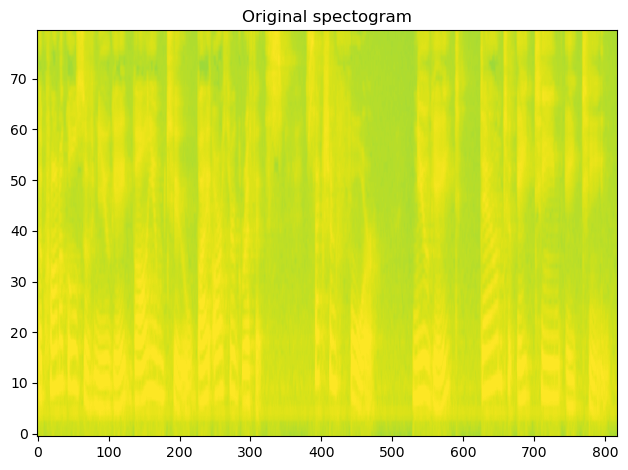

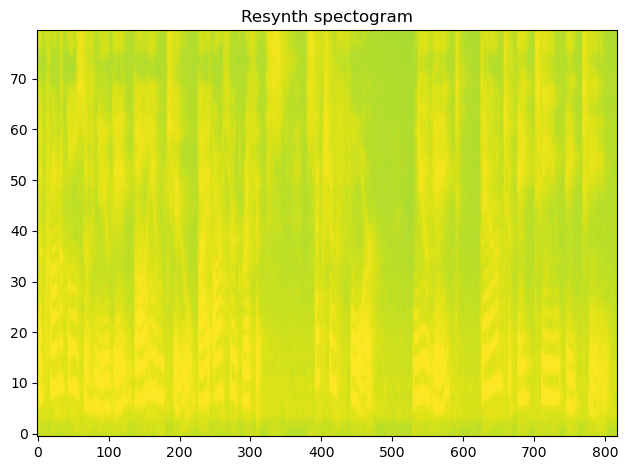

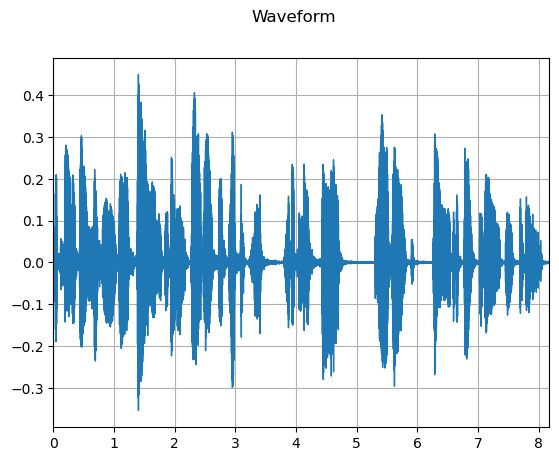

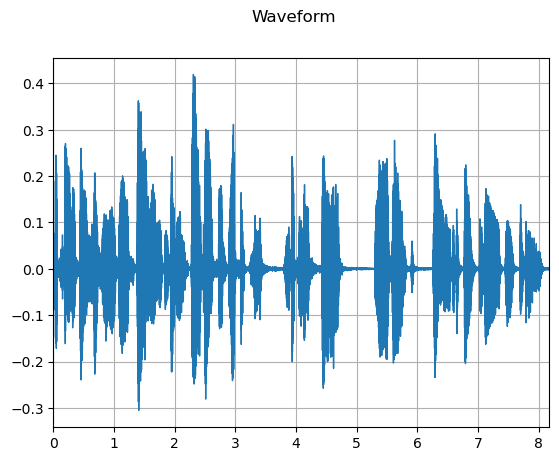

In [4]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", config.audio.sample_rate)
else:
    test = load_mono_audio("./external_datasets/lj-speech-1.1/wavs/LJ002-0001.wav", config.audio.sample_rate)
spec = spectogram(test, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)

# Generate
resynth = generator(spec.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
resynth_spec = spectogram(resynth, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(resynth_spec, title="Resynth spectogram")
plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / config.audio.sample_rate))
plot_waveform(resynth,xlim=(0,len(test) / config.audio.sample_rate))
display(Audio(data=test, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))